## Phase 2 : Prétraitement des données

### Configuration

In [44]:
import seaborn as sns 
import matplotlib as plt
import pandas as pd
import numpy as np

DATA_PATH = "../data/"
RAW_FILE = DATA_PATH + "raw/insurance.csv"
CLEAN_FILE = DATA_PATH + "process/insurance_clean.csv"
OUTPUT_PATH = "../output/"
ENCODAGE_FILE = OUTPUT_PATH + "pickle/encoders.pkl"

In [45]:
df = pd.read_csv(RAW_FILE, sep=",", header=0)

### Vérification et Traitement des Valeurs Manquantes

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Il n'y a pas de valeur manquante dans ce dataset.

### Encodage des Variables Catégorielles

In [47]:
df.describe(include=['O'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


Rappel de l'exploration : 
- `sex` et `smoker` sera encodé avec LabelEncoder ou map
- `region` sera encodé avec One-Hot Encoder

In [48]:
from sklearn.preprocessing import LabelEncoder

# Encodage binaire pour `sex` et `smoker`
sex_encoder = LabelEncoder()
smoker_encoder = LabelEncoder()
df["sex"] = sex_encoder.fit_transform(df["sex"])
df["smoker"] = smoker_encoder.fit_transform(df["smoker"])

df = pd.get_dummies(df, columns=['region'], drop_first=False)

### Vérification et Traitement des Valeurs Aberrantes

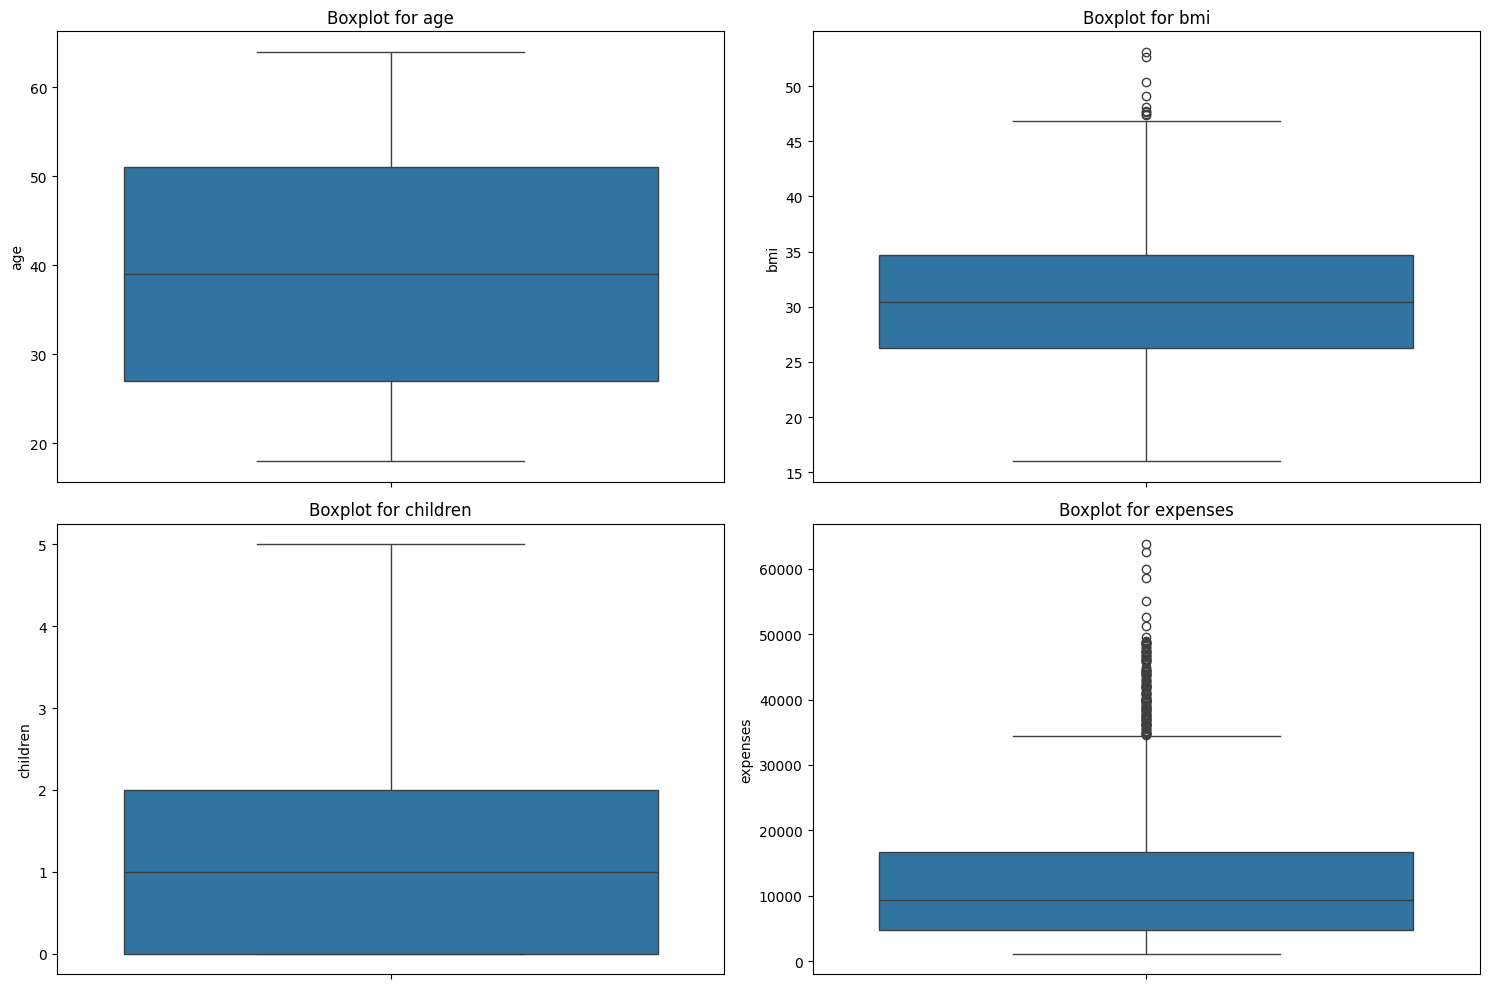

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrer uniquement les colonnes numériques
numeric_columns = ["age", "bmi", "children", "expenses"]

# Créer des boxplots pour chaque colonne numérique
plt.figure(figsize=(15, 10))  # Taille globale de la figure

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, (len(numeric_columns) + 1) // 2, i)  # Grille ajustée automatiquement
    sns.boxplot(data=df, y=column)
    plt.title(f'Boxplot for {column}')
    plt.xlabel('')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

On remarque des outliers sur deux colonnes `bmi` et `expenses`.

#### a. `bmi`

##### Visualisation des valeurs outliers

In [50]:
# Calcul des outliers pour `bmi`

# Définir Q1, Q3 et l'IQR pour la colonne 'bmi'
Q1_bmi = df["bmi"].quantile(0.25)  # Premier quartile
Q3_bmi = df["bmi"].quantile(0.75)  # Troisième quartile
IQR_bmi = Q3_bmi - Q1_bmi          # Intervalle interquartile

# Définir les bornes inférieure et supérieure
lower_bound_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bound_bmi = Q3_bmi + 1.5 * IQR_bmi

# Identifier les outliers
outliers_bmi = df[(df["bmi"] < lower_bound_bmi) | (df["bmi"] > upper_bound_bmi)]

# Afficher les valeurs des outliers pour `bmi`
print(f"limite inférieur : {lower_bound_bmi:.2f}")
print(f"limite supérieur : {upper_bound_bmi:.2f}")
outliers_bmi

limite inférieur : 13.70
limite supérieur : 47.30


,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
116,58,1,49.1,0,0,11381.33,False,False,True,False
286,46,0,48.1,2,0,9432.93,True,False,False,False
401,47,1,47.5,1,0,8083.92,False,False,True,False
543,54,0,47.4,0,1,63770.43,False,False,True,False
847,23,1,50.4,1,0,2438.06,False,False,True,False
860,37,0,47.6,2,1,46113.51,False,False,False,True
1047,22,1,52.6,1,1,44501.40,False,False,True,False
1088,52,1,47.7,1,0,9748.91,False,False,True,False
1317,18,1,53.1,0,0,1163.46,False,False,True,False


##### Analyses des outliers `bmi`

Je décide de supprimer les outliers pour la colonne `bmi`. Ces valeurs, bien que plausibles (dans la plage de 50-60), représentent des cas d'obésité sévère qui ne sont pas alignés avec mon objectif d'analyse. Je souhaite me concentrer sur les tendances générales et éviter que ces valeurs extrêmes n'influencent les résultats.

Je ne pense pas que l'IMC élevé soit fortement lié aux dépenses médicales dans ce contexte, et leur suppression permettra d'obtenir un dataset plus représentatif de la population générale. Ainsi, je vais supprimer toutes les lignes où les valeurs de bmi sont en dehors des limites définies par l'IQR.

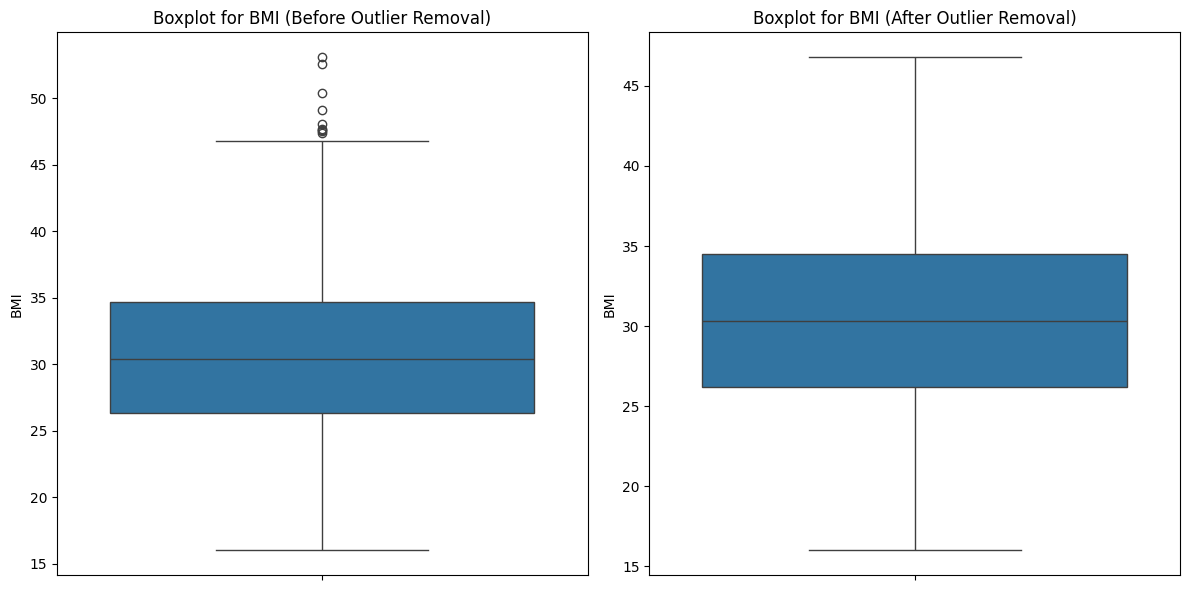

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul des limites basées sur l'IQR pour la colonne 'bmi'
Q1_bmi = df["bmi"].quantile(0.25)  # Premier quartile
Q3_bmi = df["bmi"].quantile(0.75)  # Troisième quartile
IQR_bmi = Q3_bmi - Q1_bmi          # Intervalle interquartile

lower_bound_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bound_bmi = Q3_bmi + 1.5 * IQR_bmi

# Suppression des outliers
df_cleaned = df[(df["bmi"] >= lower_bound_bmi) & (df["bmi"] <= upper_bound_bmi)]

# Visualisation du boxplot avant et après suppression
plt.figure(figsize=(12, 6))

# Boxplot avant suppression
plt.subplot(1, 2, 1)
sns.boxplot(data=df, y="bmi")
plt.title("Boxplot for BMI (Before Outlier Removal)")
plt.ylabel("BMI")

# Boxplot après suppression
plt.subplot(1, 2, 2)
sns.boxplot(data=df_cleaned, y="bmi")
plt.title("Boxplot for BMI (After Outlier Removal)")
plt.ylabel("BMI")

plt.tight_layout()
plt.show()

#### b. `expenses`

In [52]:
# Calcul des outliers pour `expenses`

# Définir Q1, Q3 et l'IQR pour la colonne 'expenses'
Q1_expenses = df["expenses"].quantile(0.25)  # Premier quartile
Q3_expenses = df["expenses"].quantile(0.75)  # Troisième quartile
IQR_expenses = Q3_expenses - Q1_expenses         # Intervalle interquartile

# Définir les bornes inférieure et supérieure
lower_bound_expenses = Q1_expenses - 1.5 * IQR_expenses
upper_bound_expenses = Q3_expenses + 1.5 * IQR_expenses

# Identifier les outliers
outliers_expenses = df[(df["expenses"] < lower_bound_expenses) | (df["expenses"] > upper_bound_expenses)]

# Afficher les valeurs des outliers pour `bmi`
print(f"limite inférieur : {lower_bound_expenses:.2f}")
print(f"limite supérieur : {upper_bound_expenses:.2f}")
outliers_expenses

limite inférieur : -13109.15
limite supérieur : 34489.36


,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
14,27,1,42.1,0,1,39611.76,False,False,True,False
19,30,1,35.3,0,1,36837.47,False,False,False,True
23,34,0,31.9,1,1,37701.88,True,False,False,False
29,31,1,36.3,2,1,38711.00,False,False,False,True
30,22,1,35.6,0,1,35585.58,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
1300,45,1,30.4,0,1,62592.87,False,False,True,False
1301,62,1,30.9,3,1,46718.16,False,True,False,False
1303,43,1,27.8,0,1,37829.72,False,False,False,True
1313,19,0,34.7,2,1,36397.58,False,False,False,True


##### Analyses des outliers `expenses`
Je décide d'appliquer une transformation logarithmique à la variable cible expenses au lieu de supprimer les outliers. Cette approche permet de réduire l'effet des valeurs extrêmes, tout en conservant l'intégralité des données. En compressant l'écart entre les valeurs, la transformation logarithmique rend la distribution plus symétrique et améliore la stabilité des modèles. Cela convient mieux à mon objectif d'analyser les tendances générales tout en tenant compte des variations réelles des dépenses.

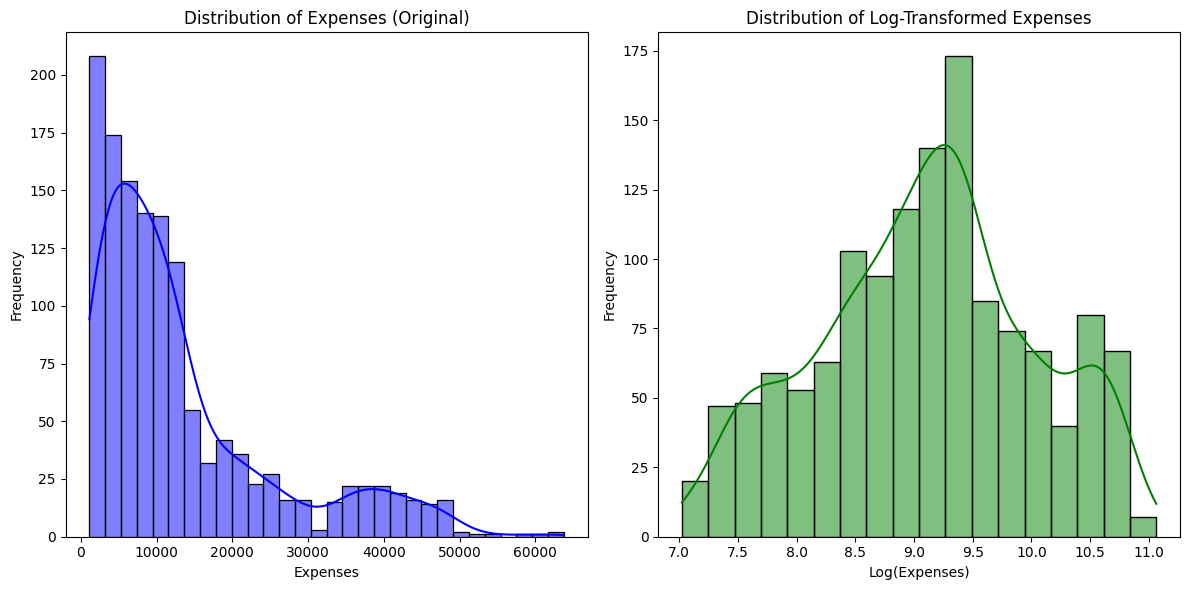

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Appliquer une transformation logarithmique à 'expenses'
df["log_expenses"] = np.log1p(df["expenses"])  # log1p(x) = log(1 + x), évite log(0)

# Visualisation avant et après transformation
plt.figure(figsize=(12, 6))

# Distribution originale
plt.subplot(1, 2, 1)
sns.histplot(df["expenses"], kde=True, color="blue")
plt.title("Distribution of Expenses (Original)")
plt.xlabel("Expenses")
plt.ylabel("Frequency")

# Distribution transformée
plt.subplot(1, 2, 2)
sns.histplot(df["log_expenses"], kde=True, color="green")
plt.title("Distribution of Log-Transformed Expenses")
plt.xlabel("Log(Expenses)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

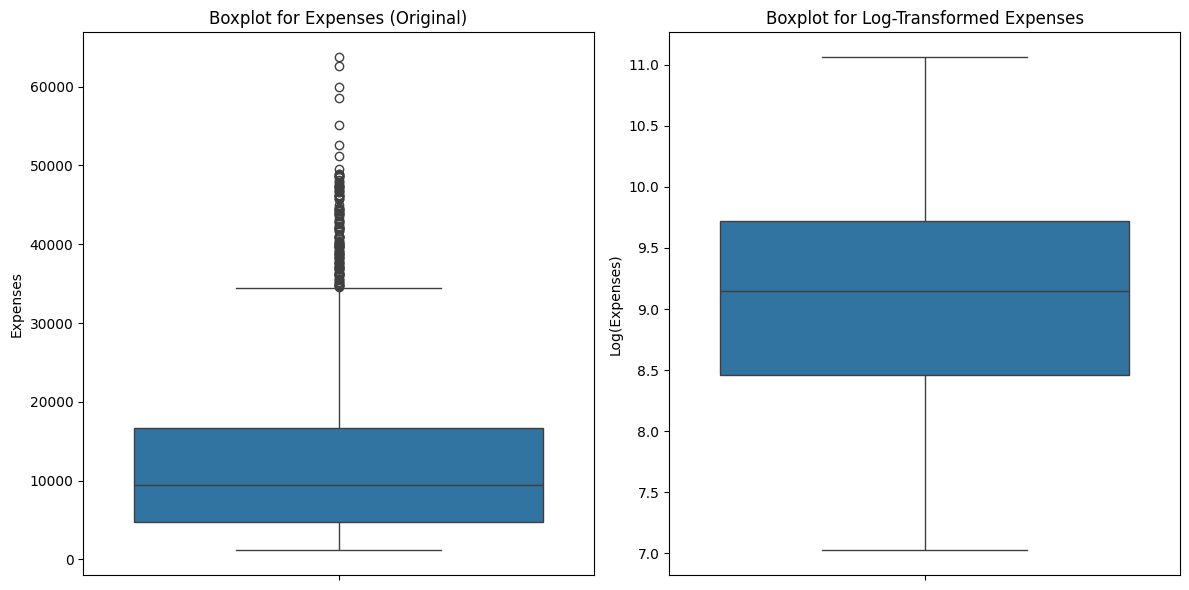

In [54]:
# Visualisation du boxplot avant et après transformation logarithmique
plt.figure(figsize=(12, 6))

# Boxplot avant transformation
plt.subplot(1, 2, 1)
sns.boxplot(data=df, y="expenses")
plt.title("Boxplot for Expenses (Original)")
plt.ylabel("Expenses")

# Boxplot après transformation
plt.subplot(1, 2, 2)
sns.boxplot(data=df, y="log_expenses")
plt.title("Boxplot for Log-Transformed Expenses")
plt.ylabel("Log(Expenses)")

plt.tight_layout()
plt.show()

#### Application de l'algorithme des outliers dans le dataset

In [55]:
# Calcul des limites basées sur l'IQR pour la colonne 'bmi'
Q1_bmi = df["bmi"].quantile(0.25)  # Premier quartile
Q3_bmi = df["bmi"].quantile(0.75)  # Troisième quartile
IQR_bmi = Q3_bmi - Q1_bmi          # Intervalle interquartile

lower_bound_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bound_bmi = Q3_bmi + 1.5 * IQR_bmi

# Suppression des outliers
df = df[(df["bmi"] >= lower_bound_bmi) & (df["bmi"] <= upper_bound_bmi)]

df["log_expenses"] = np.log1p(df["expenses"])

In [56]:
df.describe()

,age,sex,bmi,children,smoker,expenses,log_expenses
count,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000
mean,39.203913,0.504138,30.539428,1.096313,0.203913,13212.333514,9.097210
std,14.047835,0.500171,5.920164,1.207928,0.403057,11997.236428,0.916326
min,18.000000,0.000000,16.000000,0.000000,0.000000,1121.870000,7.023643
25%,27.000000,0.000000,26.200000,0.000000,0.000000,4738.270000,8.463638
50%,39.000000,1.000000,30.300000,1.000000,0.000000,9361.330000,9.144449
75%,51.000000,1.000000,34.500000,2.000000,0.000000,16586.500000,9.716405
max,64.000000,1.000000,46.800000,5.000000,1.000000,62592.870000,11.044423


### Sauvegarde du dataset

In [57]:
df.to_csv(CLEAN_FILE, index=False)

### Sauvegarde pickle de l'encodage

In [58]:
import pickle

with open(ENCODAGE_FILE, "wb") as f:
    pickle.dump({
        "dummy_columns": list(df.columns),
        "sex_encoder": sex_encoder,
        "smoker_encoder": smoker_encoder
    }, f)